In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("three_way_repeated.csv")
df.head()

,id,diet,exercises,time,score
0,1,no,no,t1,10.43
1,2,no,no,t1,11.59
2,3,no,no,t1,11.35
3,4,no,no,t1,11.12
4,5,no,no,t1,9.50


## Summary Statistics

In [4]:
stats = df.groupby(['diet', 'exercises', 'time'])['score'].agg(['count', 'std', 'mean'])
stats

count       std       mean
diet exercises time                            
no   no        t1       12  0.868473  10.909167
               t2       12  1.297581  11.565833
               t3       12  0.934792  11.450000
     yes       t1       12  1.266839  10.794167
               t2       12  1.005507  13.420833
               t3       12  1.529558  16.817500
yes  no        t1       12  0.938327  11.742500
               t2       12  1.419977  12.415833
               t3       12  1.432743  13.786667
     yes       t1       12  1.088688  11.393333
               t2       12  1.220510  13.225000
               t3       12  0.624856  14.655000

## Catplot

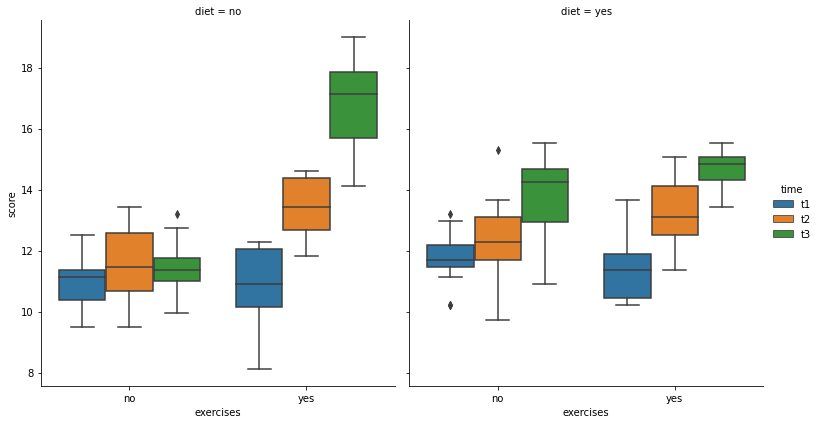

In [5]:
sns.catplot(x="exercises", y="score",
                hue="time", col="diet",
                data=df, kind="box",
                height=6, aspect=.9);

## Interaction plot using Seaborn

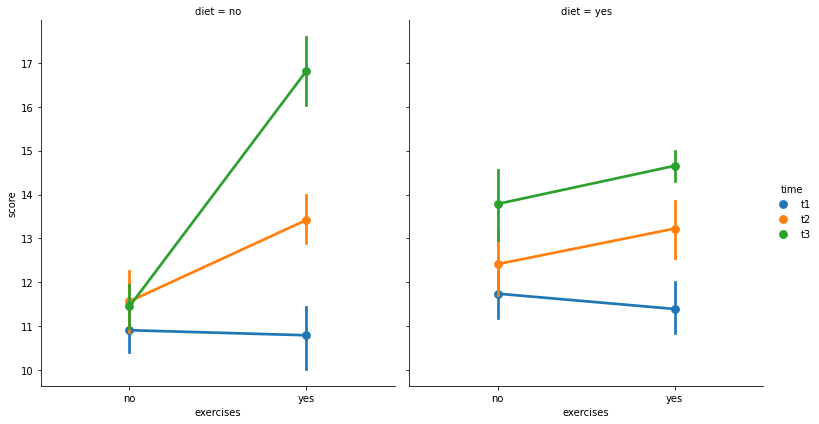

In [6]:
sns.catplot(x="exercises", y="score",
                hue="time", col="diet",
                data=df, kind="point",
                height=6, aspect=.9);

# Assumptions

### Outliers

In [7]:
def outliers(dep, ind1, ind2, ind3):
    dicts = {'Outliers':{}}
    for cat_ind1 in pd.unique(df[ind1]):
        for cat_ind2 in pd.unique(df[ind2]):
            for cat_ind3 in pd.unique(df[ind3]):
                Q1, Q3 = np.percentile(df[dep][df[ind1] == cat_ind1][df[ind2] == cat_ind2][df[ind3] == cat_ind3], [25,75])
                IQR = Q3-Q1
                lower_fence, upper_fence= Q1-(1.5*IQR), Q3+(1.5*IQR)
                new_dataset = []
                for i in df[dep][df[ind1] == cat_ind1][df[ind2] == cat_ind2][df[ind3] == cat_ind3]:
                    if i < lower_fence or i > upper_fence:
                        new_dataset.append(i)
                dicts['Outliers'][f'{cat_ind1}, {cat_ind2} and {cat_ind3}'] = new_dataset
    return pd.DataFrame(dicts)

In [8]:
outliers('score', 'time', 'diet', 'exercises')

,Outliers
"t1, no and no",[]
"t1, no and yes",[]
"t1, yes and no","[10.2, 13.21, 10.2]"
"t1, yes and yes",[]
"t2, no and no",[]
"t2, no and yes",[]
"t2, yes and no",[15.29]
"t2, yes and yes",[]
"t3, no and no",[13.21]
"t3, no and yes",[]


### Normality

In [9]:
def shapiro(dep, ind1, ind2, ind3):
    normality = {'Shapiro':{}}
    import scipy.stats as stats
    for cat_ind1 in pd.unique(df[ind1]):
        for cat_ind2 in pd.unique(df[ind2]):
            for cat_ind3 in pd.unique(df[ind3]):
                result = stats.shapiro(df[dep][df[ind1] == cat_ind1][df[ind2] == cat_ind2][df[ind3] == cat_ind3])
                normality['Shapiro'][f'{cat_ind1}, {cat_ind2} and {cat_ind3}'] = result
    return pd.DataFrame(normality)

In [10]:
shapiro('score', 'time', 'diet', 'exercises')

,Shapiro
"t1, no and no","(0.9173082113265991, 0.2643972337245941)"
"t1, no and yes","(0.9223456978797913, 0.30594387650489807)"
"t1, yes and no","(0.9422785043716431, 0.5281425714492798)"
"t1, yes and yes","(0.9141565561294556, 0.241112619638443)"
"t2, no and no","(0.9571979641914368, 0.743209719657898)"
"t2, no and yes","(0.9123399257659912, 0.22858017683029175)"
"t2, yes and no","(0.9816771745681763, 0.9894561171531677)"
"t2, yes and yes","(0.9472881555557251, 0.5977388024330139)"
"t3, no and no","(0.9649091958999634, 0.8509048223495483)"
"t3, no and yes","(0.9525445699691772, 0.6744313836097717)"


## Three-Way_Repeated ANOVA Computation

In [11]:
from statsmodels.stats.anova import AnovaRM
aovrm = AnovaRM(df, 'score', 'id', within=['diet', 'exercises', 'time'])
res = aovrm.fit()
res.summary()

,F Value,Num DF,Den DF,Pr > F
diet,6.0214,1.0000,11.0000,0.0320
exercises,58.9281,1.0000,11.0000,0.0000
time,110.9416,2.0000,22.0000,0.0000
diet:exercises,75.3561,1.0000,11.0000,0.0000
diet:time,0.6026,2.0000,22.0000,0.5562
exercises:time,20.8259,2.0000,22.0000,0.0000
diet:exercises:time,14.2461,2.0000,22.0000,0.0001


## Post-hoct tests

### Procedure for significant two-way interaction

#### Simple two-way interaction

In [12]:
# Group the data by diet and analyze the simple two-way interaction between exercises and time:

In [13]:
diet_no = df[df['diet'] == 'no']
diet_yes = df[df['diet'] == 'yes']

dataframes = [diet_no, diet_yes]
names = ['diet_no', 'diet_yes']

for i, j in zip(dataframes, names):
    aovrm = AnovaRM(i, 'score', 'id', within=['exercises', 'time'])
    res = aovrm.fit()
    summary = res.summary()
    print(f'\n{j}:\n', summary)


diet_no:
                    Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
exercises      72.7752 1.0000 11.0000 0.0000
time           71.6633 2.0000 22.0000 0.0000
exercises:time 28.9374 2.0000 22.0000 0.0000


diet_yes:
                    Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
exercises      13.4410 1.0000 11.0000 0.0037
time           20.5344 2.0000 22.0000 0.0000
exercises:time  2.5707 2.0000 22.0000 0.0992



##### Simple main effect

In [14]:
# Group the data by diet and exercises, and analyze the simple main effect of time. 

In [15]:
diet_no_exercise_no = df[df['diet'] == 'no'][df['exercises'] == 'no']
diet_no_exercise_yes = df[df['diet'] == 'no'][df['exercises'] == 'yes']
diet_yes_exercise_no = df[df['diet'] == 'yes'][df['exercises'] == 'no']
diet_yes_exercise_yes = df[df['diet'] == 'yes'][df['exercises'] == 'yes']

dataframes = [diet_no_exercise_no, diet_no_exercise_yes, diet_yes_exercise_no, diet_yes_exercise_yes]
names = ['diet_no_exercise_no', 'diet_no_exercise_yes', 'diet_yes_exercise_no', 'diet_yes_exercise_yes']

for i, j in zip(dataframes, names):
    aovrm = AnovaRM(i, 'score', 'id', within=['time'])
    res = aovrm.fit()
    summary = res.summary()
    print(f'\n{j}:\n\n',  summary)


diet_no_exercise_no:

               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
time  1.3251 2.0000 22.0000 0.2862


diet_no_exercise_yes:

               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
time 78.8148 2.0000 22.0000 0.0000


diet_yes_exercise_no:

               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
time  6.1392 2.0000 22.0000 0.0076


diet_yes_exercise_yes:

               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
time 30.9241 2.0000 22.0000 0.0000



##### Simple pairwise comparisons:

In [16]:
# run pairwise or other post-hoc comparisons if necessary.
# A statistically significant simple simple main effect can be followed up by multiple pairwise comparisons to determine which group means are different.
# Compare the different treatments by gender and risk variables:

In [17]:
diet_no_exercise_no = df[df['diet'] == 'no'][df['exercises'] == 'no']
diet_no_exercise_yes = df[df['diet'] == 'no'][df['exercises'] == 'yes']
diet_yes_exercise_no = df[df['diet'] == 'yes'][df['exercises'] == 'no']
diet_yes_exercise_yes = df[df['diet'] == 'yes'][df['exercises'] == 'yes']

dataframes = [diet_no_exercise_no, diet_no_exercise_yes, diet_yes_exercise_no, diet_yes_exercise_yes]
names = ['diet_no_exercise_no', 'diet_no_exercise_yes', 'diet_yes_exercise_no', 'diet_yes_exercise_yes']

for i, j in zip(dataframes, names):
    import pingouin as pg
    ptest = pg.pairwise_ttests(dv='score', within=['time'], subject='id', padjust='bonf', data=i)
    print(f'\n{j}:\n\n', ptest)


diet_no_exercise_no:

   Contrast   A   B  Paired  Parametric         T   dof alternative     p-unc  \
0     time  t1  t2    True        True -1.490953  11.0   two-sided  0.164083   
1     time  t1  t3    True        True -1.766705  11.0   two-sided  0.104975   
2     time  t2  t3    True        True  0.223505  11.0   two-sided  0.827239   

     p-corr p-adjust   BF10    hedges  
0  0.492248     bonf  0.696 -0.574257  
1  0.314925     bonf  0.954 -0.578763  
2  1.000000     bonf  0.294  0.098900  

diet_no_exercise_yes:

   Contrast   A   B  Paired  Parametric          T   dof alternative  \
0     time  t1  t2    True        True  -5.313222  11.0   two-sided   
1     time  t1  t3    True        True -16.556049  11.0   two-sided   
2     time  t2  t3    True        True  -6.028161  11.0   two-sided   

          p-unc        p-corr p-adjust       BF10    hedges  
0  2.473446e-04  7.420338e-04     bonf    131.958 -2.217519  
1  4.015604e-09  1.204681e-08     bonf  2.341e+06 -4.141140  

# Report

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

yes_t2 vs. yes_t3: Custom statistical test, P_val:2.572e-04
no_t1 vs. no_t2: Custom statistical test, P_val:4.922e-01
no_t2 vs. no_t3: Custom statistical test, P_val:1.000e+00
yes_t1 vs. yes_t2: Custom statistical test, P_val:7.420e-04
yes_t1 vs. yes_t3: Custom statistical test, P_val:1.205e-08
no_t1 vs. no_t3: Custom statistical test, P_val:3.149e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

yes_t2 vs. yes_t3: Custom statistical test, P_val:2.038e-02
no_t1 vs. no_t2: Custom statistical test, P_val:5.782e-01
no_t2 vs. no_t3: Custom statistical test, P_val:2.741e-01
yes_t1 vs. yes_t2: Custom statistical test, P_val:9.657e-03
yes_t1 vs. yes_t3: Custom statistical test, P_va

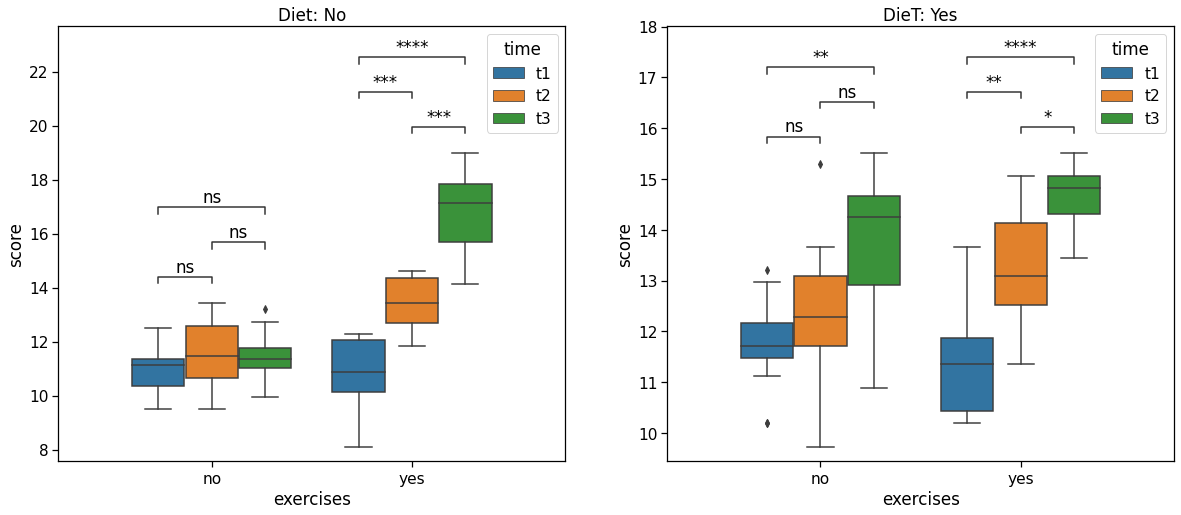

In [18]:
from statannotations.Annotator import Annotator

# palette = sns.color_palette("YlGnBu", n_colors=3)

hue_order = ["t1", "t2", 't3']
subcat_order = ['no', 'yes']

no_diet_pvalues = [0.4922, 0.314925, 1, 7.420338e-04, 1.204681e-08, 2.571840e-04]
yes_diet_pvalues = [0.578203, 0.007543, 0.274081, 0.009657, 0.000001, 0.020375]

# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls..
no_diet_pairs = [
    [('no', 't1'), ('no', 't2')],
    [('no', 't1'), ('no', 't3')],
    [('no', 't2'), ('no', 't3')],
    
    [('yes', 't1'), ('yes', 't2')],
    [('yes', 't1'), ('yes', 't3')],
    [('yes', 't2'), ('yes', 't3')],
]

yes_diet_pairs = [
    [('no', 't1'), ('no', 't2')],
    [('no', 't1'), ('no', 't3')],
    [('no', 't2'), ('no', 't3')],
    
    [('yes', 't1'), ('yes', 't2')],
    [('yes', 't1'), ('yes', 't3')],
    [('yes', 't2'), ('yes', 't3')],  
]

no_diet_plotting_parameters = {
    'data': df[df['diet']=='no'],
    'x': 'exercises',
    'y': 'score',
    "order": subcat_order,
    "hue": "time",
    "hue_order": hue_order,
#     "palette": palette,
}

yes_diet_plotting_parameters = {
    'data': df[df['diet']=='yes'],
    'x': 'exercises',
    'y': 'score',
    "order": subcat_order,
    "hue": "time",
    "hue_order": hue_order,
#     "palette": palette,
}

with sns.plotting_context('notebook', font_scale = 1.4):
    from matplotlib import pyplot as plt
    
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

    ax1 = sns.boxplot(**no_diet_plotting_parameters, ax=ax1)
    ax1.set_title("Diet: No")
    
    ax2 = sns.boxplot(**yes_diet_plotting_parameters, ax=ax2)
    ax2.set_title("DieT: Yes")

    # Add annotations
    annotator = Annotator(ax1, no_diet_pairs, **no_diet_plotting_parameters)
    annotator.set_pvalues(no_diet_pvalues)
    annotator.annotate()

    annotator = Annotator(ax2, yes_diet_pairs, **yes_diet_plotting_parameters)
    annotator.set_pvalues(yes_diet_pvalues)
    annotator.annotate()
    
    plt.show()